Following the method of Hawthorne and Ampuero (20**)

## Getting set up
#### conda enviroment

This code only has a number of dependencies. Create an enviroment following

```bash
conda env create -f environment.yml   # or other supported Python version <\code>
conda activate phasecoherence  # this command used to be 'source activate obspy' on older conda versions < 4.4
(phase coherence) $ 
```
    
#### Inputs
- Data : continuous data you want to search, with picks saved into SAC file as t3
- Template: data you want to take the template from, with picks saved into SAC file as t3 (could be the same as data, a shorter window of same data, or very different)

## Preparation

### Imports

#### standard imports

In [12]:
import numpy as np
import datetime
import obspy
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#### special imports

In [2]:
import databseis
import seisproc
from PhaseCoherence import PhaseCoherence as PC
import NZfunctions
import PC_calculator

### Load data

In [14]:
eqFolders = NZfunctions.NZopenEQList()
j=1
D = NZfunctions.NZLoadData(eqFolders[j],'sac') #data
T = NZfunctions.NZLoadTempl(eqFolders[j]) #template

### Parameters to choose

#### Template
The duration of the template and the buffer either side can be varied

In [15]:
# window for template, 
wintemp = [-1,2] # from 1 second before pick to 2 seconds after

# we'll buffer by buftemp on either side of the template
# the template tapers to zero with a cosine taper within the buffer
buftemp = 0.3


#### bandpass limits
The data will be bandpass filtered. You can choose the limits as appropriate for your data

In [16]:
# frequency range (Hz)
blim=[1,10]

#### computation windows
The phase coherence can be calculated on windows of different lengths, and with different overlaps.

In [17]:
# Windows where PC is computed are wlenlook seconds long
wlenlook=1. 
# Windows are separated by dtl seconds
dtl = 0.2 # Windows are separated by dtl seconds
trange=[-3600,3600] # Relative to pick (t3) how long we want to look at (1 hour either side)
shift = []
tlook = np.arange(-1800,1800,1.) #times to start window at

### Other parameters
Other parameters are fixed or automatically calculated:

In [18]:
# we need to highpass filter to avoid aliasing
hpfilt=np.minimum(np.diff(wintemp)[0],wlenlook)
hpfilt=3/hpfilt

# Get time shifts based on arrival time differences
shifts = {}
lini = 99999999.
databseis.copyfromsacheader(T)
databseis.copyfromsacheader(D)
for tr in T:
    nid = tr.stats.network+'.'+tr.stats.station+'.'+tr.stats.channel[-1]
    shifts[nid] = tr.stats.t3 
    if float(tr.stats.t3 )<float(lini):
        lini=tr.stats.t3 
        
# Make sure smallest time-shift is 0.
for k in shifts.keys():
    shifts[k] = 0.

### Extracting and processing data

We can extract info from the waveforms of D and T, and prepare it for the final plotting

In [19]:
toPlot = D[0].copy()
D.merge()   
Dtimes = toPlot.times()
databseis.copyfromsacheader(toPlot)
Ddates = Dtimes - toPlot.stats.t3 #for x-axis of plot

We also filter the data and mask it as needed

In [20]:
mskD=seisproc.prepfiltmask(D)
mskT=seisproc.prepfiltmask(T)
T.filter('bandpass',freqmin=hpfilt,freqmax=19, zerophase = True)
D.filter('bandpass',freqmin=hpfilt,freqmax=19, zerophase = True) 
seisproc.addfiltmask(D,mskD)
seisproc.addfiltmask(T,mskT)
starttime = D[0].stats.starttime.datetime

## Now we compute phase coherence

In [21]:
# Compute PC
P,t = PC_calculator.computePC(T,D,wintemp,buftemp,tlook,wlenlook,blim,None,shifts,None)

## Finally, we plot the results
To show the results, we plot seismogram, interstation and intercomponent phase coherences alongside each other


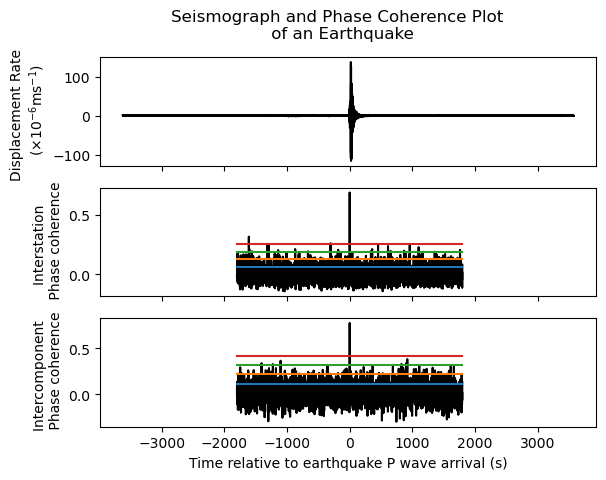

In [22]:
gain = 2.51658E+03
figure, ax = plt.subplots(3, sharex=True)
figure.suptitle('Seismograph and Phase Coherence Plot \n of an Earthquake')
ax[0].plot(Ddates,toPlot.data/gain,'k')

sd = np.std(P.Cp['Cpstat'])
mean = np.mean(P.Cp['Cpstat'])
sdComp = np.std(P.Cp['Cpcomp'])
meanComp = np.mean(P.Cp['Cpcomp'])
    

ax[1].plot(P.params['tlook'],P.Cp['Cpstat'],'k')
ax[1].plot([-1800,1800],[1*sd+mean,1*sd+mean])
ax[1].plot([-1800,1800],[2*sd+mean,2*sd+mean])
ax[1].plot([-1800,1800],[3*sd+mean,3*sd+mean])
ax[1].plot([-1800,1800],[4*sd+mean,4*sd+mean])
#ax[1].set_xlabel('Time relative to earthquake P wave arrival (s)')
ax[1].set_ylabel('Interstation \n Phase coherence')

ax[2].plot(P.params['tlook'],P.Cp['Cpcomp'],'k')
ax[2].plot([-1800,1800],[1*sdComp+meanComp,1*sdComp+meanComp])
ax[2].plot([-1800,1800],[2*sdComp+meanComp,2*sdComp+meanComp])
ax[2].plot([-1800,1800],[3*sdComp+meanComp,3*sdComp+meanComp])
ax[2].plot([-1800,1800],[4*sdComp+meanComp,4*sdComp+meanComp])
ax[2].set_xlabel('Time relative to earthquake P wave arrival (s)')
ax[2].set_ylabel('Intercomponent \n Phase coherence')

ax[0].set_ylabel('Displacement Rate \n ($×10^{-6}$ms$^{-1}$)')
plt.show()